In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import dlib
import time
import math
from mpl_toolkits.mplot3d import Axes3D

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

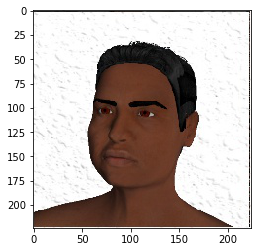

In [3]:
#读取图像
img0 = cv2.imread('man.jpg')
img = img0[:,:,::-1] # 必须为 ::-1
plt.imshow(img) 
plt.show()

In [4]:
# 提取68个特征点
def get_landmarks68(img):
    rects = detector(img, 1)
    if len(rects) == 0:
        return -1
    return np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])
# 注释68个标记点
def annotate_landmarks68(im):
    img = im.copy()
    landmarks68=get_landmarks68(img)
    for idx, point in enumerate(landmarks68):
        pos = (point[0, 0], point[0, 1])
        #cv2.putText(img, str(idx), pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.4,color=(0, 0, 255))
        cv2.circle(img, pos, 3, color=(0, 255, 255))
    return img

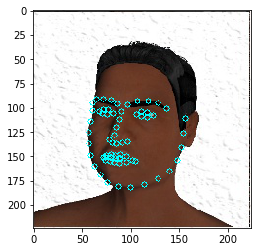

In [5]:
a=annotate_landmarks68(img)
plt.imshow(a)
plt.show()

In [6]:
# 手动构建7点人脸3D模型
def model_3D():
    '''
    手动构建7点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型7点矩阵
    '''
    model_points = np.array([
        (-225.0, 170.0, -135.0),  # 左眼左眼角
        (-75.0, 170.0, -135.0),  # 左眼右眼角，自己定的
        (75.0, 170.0, -135.0),  # 右眼左眼角，自己定的
        (225.0, 170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (-150.0, -150.0, -125.0),  # 左嘴角
        (150.0, -150.0, -125.0)  # 右嘴角
    ])
    return model_points

[[-225.  170. -135.]
 [ -75.  170. -135.]
 [  75.  170. -135.]
 [ 225.  170. -135.]
 [   0.    0.    0.]
 [-150. -150. -125.]
 [ 150. -150. -125.]]


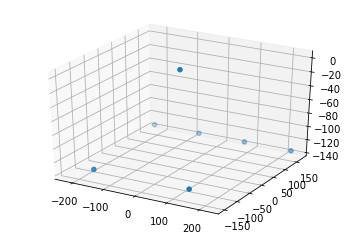

In [7]:
model_points=model_3D()
print(model_points)
ax = plt.subplot(111, projection='3d')
ax.scatter(model_points.T[0],model_points.T[1],model_points.T[2])
plt.show()

In [8]:
# 获取最大的人脸
def largest_face(faces):
    '''
    求最大的人脸
    :param faces:detectors检测到的多个人脸的array
    :return:最大人脸的index
    '''
    if len(faces) == 1:
        return 0
    face_areas = [(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]  # 求脸的大小
    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(faces)):  # 取最大的脸
        if face_areas[index] > largest_area:
            largest_index = index
            largest_area = face_areas[index]
    print("largest_face index is {} in {} faces".format(largest_index, len(faces)))
    return largest_index

In [9]:
# dlib获取人脸7特征点
def get_landmark7(img):
    '''
    用dlib获取人脸7个特征点
    :param img: 输入图片
    :return: 人脸7特征点矩阵(0, landmark7)，若未检测到人脸，返回(-1，None)
    '''
    faces = detector(img, 0)  # 检测图片中的所有人脸,网上都是1，cvdlib中是0
    if len(faces) == 0:  # 没有检测到人脸
        print("ERROR: found no face")
        return -1, None
    largest_index = largest_face(faces)  # 取最大人脸
    face_rectangle = faces[largest_index]  # 取对应人脸框
    landmark68 = predictor(img, face_rectangle)  # dlib检测人脸特征68点
    landmark7 = np.array([  # 取出68点中所需的7个点
        (landmark68.part(36).x, landmark68.part(36).y),  # 左眼左眼角
        (landmark68.part(39).x, landmark68.part(39).y),  # 左眼右眼角
        (landmark68.part(42).x, landmark68.part(42).y),  # 右眼左眼角
        (landmark68.part(45).x, landmark68.part(45).y),  # 右眼右眼角
        (landmark68.part(30).x, landmark68.part(30).y),  # 鼻尖
        (landmark68.part(48).x, landmark68.part(48).y),  # 左嘴角
        (landmark68.part(54).x, landmark68.part(54).y)  # 右嘴角
    ], dtype="double")
    return 0, landmark7

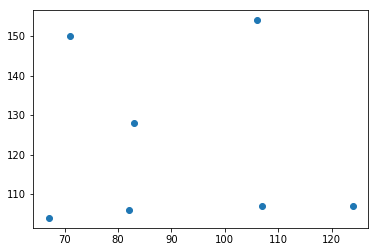

In [10]:
image_points=get_landmark7(img)[1]
image_points
plt.scatter(image_points.T[0],image_points.T[1])
plt.show()

In [22]:
# 求旋转矩阵和平移矩阵
def get_rot_trans(img_size, landmark7):
    '''
    手动建立人脸3D模型，根据2D人脸特征点求旋转向量和平移向量
    :param img_size:长×宽
    :param landmark7: 2D人脸特征点
    :return: success, rotation_vector, translation_vector, camera_matrix, dist_coeffs
    '''
    # 3D模型
    model_points = model_3D()

    # 相机内参
    focal_length = img_size[1]  # 焦距
    center = (img_size[1] / 2, img_size[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    print("Camera Matrix :{}".format(camera_matrix))
    distortion_coeffs = np.zeros((4, 1))  # 假设没有透镜畸变
    # 透视变换
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, landmark7, camera_matrix,
                                                                  distortion_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
    print("Rotation Vector:\n {}".format(rotation_vector))
    print("Translation Vector:\n {}".format(translation_vector))
    return success, rotation_vector, translation_vector, camera_matrix, distortion_coeffs

In [23]:
success, rotation_vector, translation_vector, camera_matrix, distortion_coeffs=get_rot_trans(img.shape, image_points[1])

Camera Matrix :[[ 224.    0.  112.]
 [   0.  224.  112.]
 [   0.    0.    1.]]


error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\calib3d\src\solvepnp.cpp:65: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) ) && npoints == std::max(ipoints.checkVector(2, 5), ipoints.checkVector(2, 6)) in function 'cv::solvePnP'


In [16]:
# 从旋转向量转换为欧拉角
def get_euler_angle(rotation_vector):
    '''
    从旋转向量转换为欧拉角
    :param rotation_vector: 旋转向量
    :return: 欧拉角
    '''
    # calculate rotation angles
    theta = cv2.norm(rotation_vector, cv2.NORM_L2)

    # transformed to quaterniond
    w = math.cos(theta / 2)
    x = math.sin(theta / 2) * rotation_vector[0][0] / theta
    y = math.sin(theta / 2) * rotation_vector[1][0] / theta
    z = math.sin(theta / 2) * rotation_vector[2][0] / theta

    ysqr = y * y
    # pitch (x-axis rotation)
    t0 = 2.0 * (w * x + y * z)
    t1 = 1.0 - 2.0 * (x * x + ysqr)
    #print('t0:{}, t1:{}'.format(t0, t1))
    pitch = math.atan2(t0, t1)

    # yaw (y-axis rotation)
    t2 = 2.0 * (w * y - z * x)
    if t2 > 1.0:
        t2 = 1.0
    if t2 < -1.0:
        t2 = -1.0
    yaw = math.asin(t2)

    # roll (z-axis rotation)
    t3 = 2.0 * (w * z + x * y)
    t4 = 1.0 - 2.0 * (ysqr + z * z)
    roll = math.atan2(t3, t4)

    #print('pitch:{}, yaw:{}, roll:{}'.format(pitch, yaw, roll))

    # 单位转换：将弧度转换为度
    Y = int((pitch / math.pi) * 180)
    X = int((yaw / math.pi) * 180)
    Z = int((roll / math.pi) * 180)

    return 0, Y, X, Z

In [17]:
# 画表示姿势的线
def draw_line(img, landmark7, rotation_vector, translation_vector, camera_matrix, distortion_coeffs):
    '''
    画表示姿势的线
    :param img: 输入图像
    :param landmark7:2D人脸7个特征点
    :param rotation_vector:旋转向量
    :param translation_vector:平移向量
    :param camera_matrix:相机内参
    :param distortion_coeffs:透镜畸变参数
    :return:
    '''
    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]),
                                                     rotation_vector, translation_vector, camera_matrix,
                                                     distortion_coeffs)
    p1 = (int(landmark7[4][0]), int(landmark7[4][1]))  # 鼻尖
    p2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    print('----------------------------------------------------------------------')
    print('p1=',p1)
    print('p2=',p2)
    img_with_line = np.copy(img)
    cv2.line(img_with_line, p1, p2, (255, 0, 0), 2)
    return img_with_line

In [18]:
# 计算头部姿势
def pose_estimation(img, img_size):
    '''
    计算头部姿势
    :param img: 输入图片
    :param img_szie: 输入图片大小
    :return: 头部姿势(0, pitch, yaw, roll)
    '''
    try:
        ret, landmark7 = get_landmark7(img)
        if ret != 0:
            print('get_landmark7 failed')
            return -1, None, None, None

        ret, rotation_vector, translation_vector, camera_matrix, dist_coeffs = get_rot_trans(img_size, landmark7)
        if ret != True:
            print('get_pose_estimation failed')
            return -1, None, None, None

        ret, pitch, yaw, roll = get_euler_angle(rotation_vector)
        if ret != 0:
            print('get_euler_angle failed')
            return -1, None, None, None

        euler_angle_str = 'Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll)
        img_with_line = draw_line(img, landmark7, rotation_vector, translation_vector, camera_matrix, distortion_coeffs)
        print(euler_angle_str)
        return img_with_line, pitch, yaw, roll

    except Exception as e:
        print('pose_estimation exception:{}'.format(e))
        return -1, None, None, None

In [19]:
ret, pitch, yaw, roll=pose_estimation(img, img.shape)
euler_angle_str = 'Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll)

pose_estimation exception:name 'distortion_coeffs' is not defined


In [ ]:
# 读取图像
img0 = cv2.imread('man.jpg')
img = img0[:, :, ::-1]  # 必须为 ::-1
# 获取7个特征点
landmark7 = get_landmark7(img)
# 计算旋转矩阵、平移矩阵、相机内参、畸变参数
success, rotation_vector, translation_vector, camera_matrix, distortion_coeffs = get_rot_trans(img.shape, landmark7[1])
# 计算欧拉角姿势
img_with_line, pitch, yaw, roll = pose_estimation(img, img.shape)
# 显示
plt.imshow(img_with_line)
plt.title('Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll))
plt.show()